In [1]:
import sys 
sys.path.append("../src/")

import math
from tqdm import tqdm

from GraphBuilder import GraphBuilder
from GraphState import GraphState, GraphEvaluator
from GeneticEvaluatorOptim import GeneticEvaluator
from HybridEvaluator import HybridEvaluator
from MCSTree import MCST,State, MonteCarloTreeNode, Policies
from MCSTreeUtils import MCSTreeGraph
from GrammarLoader import GrammarLoader
from GraphUtils import *

C:\Users\smora\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [155]:
# import math
import math
from typing import Tuple, Dict, List
import json
import networkx as nx
import numpy as np
from GraphState import GraphEvaluator, GraphState
from GeneticAlgorithm import GeneticAlgorithm, Individual, ExponentialRankSelector, PartiallyMappedCrossover, ReverseSequenceMutation, SinglePointCrossover, SimpleBoundedMutation


from typing import Dict, List
import json
import math

class MappingEvaluator():
    
    def __init__(self, data_flows, graph=None):
        self.data_flows=data_flows        
        self.graph=graph
        
        if graph is not None:
             self.module_list = list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'M'])
            
        self.shortest_paths = {}
        self.simple_paths = {}
        self.switch_paths = {}
        
    def calculate_SW_connectivity(self,graph,cutoff=3):
        
        switch_connectivity=0
        switch_list=list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'S'])
        
        count=0
        
        for s in switch_list:
            leaves = [d for d in switch_list if d!=s and (s,d) not in self.switch_paths]
            count+=len(leaves )
            if len(leaves)>0:
                paths = nx.all_simple_paths(graph, s, leaves, cutoff=6)
                for path in paths:
                    path=list(path)
                    if (s, path[-1]) in self.switch_paths:
                        self.switch_paths[(s,path[-1])]+=1
                        n_paths=self.switch_paths[(s,path[-1])]
                        if n_paths==2:
                            switch_connectivity+=1
                    else: 
                        self.switch_paths[(s,path[-1])]=1    
                                              
        return len([n for n in self.switch_paths.values() if n>1])/max(1,len(list(self.switch_paths.values())))
                   
    def count_hops(self,graph,module_list):
        
        hops=np.zeros(len(self.data_flows))
        for index, c in enumerate(self.data_flows):
            if (module_list[c[0]], module_list[c[1]]) not in self.shortest_paths:
                try:
                    shortest_path = list(nx.shortest_path(graph, source=module_list[c[0]], target=module_list[c[1]]))
                except nx.NetworkXNoPath:
                    return None
                
                self.shortest_paths[(module_list[c[0]], module_list[c[1]])]=shortest_path
            else:
                shortest_path=self.shortest_paths[(module_list[c[0]], module_list[c[1]])]
            hops[index] = len(shortest_path)-1
                
        return hops
    
    def calculate_link_loads(self,graph,module_list,edge_list):
        
        edge_loads = np.zeros(len(edge_list))
    
        for index, c in enumerate(self.data_flows):
            if (module_list[c[0]], module_list[c[1]]) not in self.shortest_paths:
                try:
                    shortest_path = list(nx.shortest_path(graph, source=module_list[c[0]], target=module_list[c[1]])) 
                except nx.NetworkXNoPath:
                    return None
                    
                self.shortest_paths[(module_list[c[0]], module_list[c[1]])]=shortest_path
            else:
                shortest_path=self.shortest_paths[(module_list[c[0]], module_list[c[1]])]
            for h in range(0, len(shortest_path) - 1):
                edge_loads[edge_list.index((shortest_path[h], shortest_path[h + 1]))] += c[2]
        
        return edge_loads
        
    def count_link_overloads(self,loads,target):
        return (loads / 100e6 > target).sum()
    
    def max_link_load(self,loads):
        return np.max(loads / 100e6)
    
        
    def calculate_LC_scores(self, graph, module_list, alpha=1):
        max_load_target=0.79999999999
        
        edge_list = list(graph.edges())
        
        
        loads = self.calculate_link_loads(graph,module_list,edge_list)
        hops = self.count_hops(graph,module_list)
        
        if loads is not None and hops is not None: 
            max_load = self.max_link_load(loads)
            overload_count = self.count_link_overloads(loads,max_load_target)
            mean_hops = np.mean(hops)
            max_hops = np.max(hops).astype(int)
            latency_score = 2*math.exp(1-max_load/max_load_target   - overload_count)/mean_hops
            
            for i,e in enumerate(edge_list):
                graph.edges[e]["utilization"] = loads[i] / 100e6
        else:
            overload_count="N.A"
            max_hops=float("inf")
            mean_hops=float("inf")
            max_load="N.A"
            latency_score=1e-9
        
        SW_connectivity = self.calculate_SW_connectivity(graph,cutoff=max_hops+2)

        connectivity_score = alpha*SW_connectivity
        
        return latency_score, connectivity_score, \
                                {'max_load': max_load, 'overload_count':overload_count, 'mean_hops': mean_hops,\
                               'max_hops': max_hops, 'latency_score':latency_score,'connectivity_score':connectivity_score,\
                               'SW_connectivity':SW_connectivity}
    
    def evaluate(self, individual : Individual):
        
        if isinstance(individual,Individual): 
            ordering_list = individual.genome 
            if self.graph is not None:
                module_order=[self.module_list[n] for n in ordering_list] 
                latency, connectivity, stats=self.calculate_LC_scores(self.graph,module_order,alpha=1)
                beta=0.25
                return (latency*(1-beta)+connectivity*(beta))
            else:
                raise Exception("Evaluate can only be used if graph is set")
        else:
                raise TypeError("Evaluate argument has to be a genetic algorithm individual")
                

class RoutingEvaluator():
    
    def __init__(self, data_flows, path_dict,graph=None):
        self.data_flows=data_flows        
        self.graph=graph
        self.path_dict = path_dict
                           
    def count_hops(self,path_list):
        
        paths=[self.path_dict[(self.data_flows[i][0],self.data_flows[i][1])][1][p] for i,p in enumerate(path_list)]
        hops=[self.path_dict[(self.data_flows[i][0],self.data_flows[i][1])][2][p] for i,p in enumerate(path_list)] 
        return hops
    
    def calculate_link_loads(self,graph,path_list,edge_list):
        
        edge_loads = np.zeros(len(edge_list))
        paths=[self.path_dict[(self.data_flows[i][0],self.data_flows[i][1])][1][p] for i,p in enumerate(path_list)]
        bw=[self.data_flows[i][2] for i,_ in enumerate(path_list)]
        
     
        for i,p in enumerate(paths):
            if isinstance(p, list):
                #print(p)
                for h in range(0, len(p) - 1):
                   
                    #print((p[h], p[h + 1]))
                    edge_loads[edge_list.index((p[h], p[h + 1]))] += bw[i]
            
        return edge_loads
        
    def count_link_overloads(self,loads,target):
        return (loads / 100e6 > target).sum()
    
    def max_link_load(self,loads):
        return np.max(loads / 100e6)
    
        
    def calculate_latency_scores(self, graph, path_list, alpha=1):
        max_load_target=0.79999999999
        
        edge_list = list(graph.edges())
        
        
        loads = self.calculate_link_loads(graph,path_list,edge_list)
        hops = self.count_hops(path_list)
        #print(hops)
        
        if loads is not None and hops is not None: 
           
            max_load = max(max_load_target,self.max_link_load(loads))
            overload_count = self.count_link_overloads(loads,max_load_target)
            #print(overload_count)
            #print(loads/100e6)
            mean_hops = np.mean(hops)
            max_hops = np.max(hops).astype(int)
            latency_score = 2*math.exp(1-max_load/max_load_target   - overload_count)/mean_hops
            
            for i,e in enumerate(edge_list):
                if loads[i]>0.0:
                    graph.edges[e]["utilization"] = loads[i] / 100e6
        
        else:
            print("FELLLL HERE")
            overload_count="N.A"
            max_hops=float("inf")
            mean_hops=float("inf")
            max_load="N.A"
            latency_score=1e-9
        
        return latency_score, {'max_load': max_load, 'overload_count':overload_count, 'mean_hops': mean_hops, 'max_hops': max_hops, 'latency_score':latency_score,}
    
    def evaluate(self, individual : Individual):
        if isinstance(individual,Individual): 
            path_list = individual.genome 
            if self.graph is not None:
                latency, stats=self.calculate_latency_scores(self.graph,path_list,alpha=1)
                return latency
            else:
                raise Exception("Evaluate can only be used if graph is set")
        else:
                raise TypeError("Evaluate argument has to be a genetic algorithm individual")
   

class GeneticRouter(GraphEvaluator):
    module_threshold : int
    generations : int
    weights : Dict[str,float]
    data_flows : List[tuple[int,int,float]]
    


    def __init__(self, weights : Dict[str,float], module_threshold: int =0, pop_size : int =50, generations : int = 3, filename : str ="data/connections.json",seed=12345):
        self.pop_size = pop_size 
        self.generations = generations 
        self.module_threshold=module_threshold
        self.weights = weights
        self.rng = np.random.default_rng(seed)
      
        

        with open(filename) as file:
            self.data_flows = json.loads(json.load(file))
        
        self.data_flows=[f for f in self.data_flows if f[0] <19]
        self.module_threshold=max([max(f[0],f[1]) for f in self.data_flows])+1
    
    def update_seed(self,seed):
        self.rng = np.random.default_rng(seed)

    def __str__(self) -> str:
        ret_str = f"module_threshold: {self.module_threshold}\n"
        ret_str += f"pop_size: {self.pop_size} \n"
        ret_str += f"generations {self.generations} \n"
        ret_str += str(self.weights)

        return ret_str


    def trim_graph(self, graph):
        graph
        nodes_to_remove=[]
        changed=True
        while(changed):
            changed=False
            for x,y in graph.nodes(data=True):
                if graph.degree(x) >2 and y['idType']=='M':
                    edges_to_remove=[(x,z) for z  in graph.neighbors(x)][0:-1]+[(z,x) for z in graph.neighbors(x)][0:-1]
                    graph.remove_edges_from(edges_to_remove)
                    changed=True
                if graph.degree(x) <=2 and y['idType']=='S':
                    switches=[n for n in graph.neighbors(x) if graph.nodes[n]["idType"]=='S']
                    if len(switches)==1:
                        nodes_to_remove.append(x)
                        changed=True
                elif graph.degree(x) == 4 and y['idType']=='S':
                    switches=[n for n in graph.neighbors(x) if graph.nodes[n]["idType"]=='S']
                    modules=[n for n in graph.neighbors(x) if graph.nodes[n]["idType"]=='M']
                    if len(switches)==1 and len(modules)==1:
                        nodes_to_remove.append(x)
                        graph.add_edge(switches[0],modules[0])
                        graph.add_edge(modules[0],switches[0])
                        changed=True
            graph.remove_nodes_from(nodes_to_remove)     
    
   

    def evaluate_LC(self, graph,alpha=1):

        module_list = list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'M'])
        all_connected = sum([1 for x in module_list if graph.degree(x) ==2 ])
            
        genome_size = len(module_list)
        
        mapping_evaluator=MappingEvaluator(self.data_flows,graph=graph)
        
        
        if all_connected<self.module_threshold:
            SW_connectivity=mapping_evaluator.calculate_SW_connectivity(graph,6)
            connectivity_score=SW_connectivity*(alpha)
            #connectivity_score=0
            return 0, connectivity_score, \
                    {'connectivity_score': connectivity_score,'SW_connectivity':SW_connectivity,'latency_score':0}, \
                    module_list
        
   
        seed_sel=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        seed_cross=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        seed_mut=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        
        selector=ExponentialRankSelector(seed=seed_sel)
        crossop=PartiallyMappedCrossover(seed=seed_cross)
        mutop=ReverseSequenceMutation(seed=seed_mut)
        
              
        class MappingGenomeInitializer:
            def __init__(self, seed=None):
                self.rng=np.random.default_rng(seed)
            def __call__(self,genome):
                linspace=np.linspace(start=0,stop=len(genome)-1, num=len(genome),dtype=int)
                self.rng.shuffle(linspace)
                return linspace
        
        seed_init=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        init_fn=MappingGenomeInitializer(seed_init)
        
        ga = GeneticAlgorithm(genome_size = genome_size, crossover_operator=crossop, 
                          mutation_operator=mutop, evaluator=mapping_evaluator, selector=selector)

        individuals, fitness= ga.run(pop_size = self.pop_size, generations=self.generations, init_fn=init_fn)
        
    
        module_list=[module_list[n] for n in individuals[0].genome]
        latency_score,connectivity_score,stats=mapping_evaluator.calculate_LC_scores(graph,module_list,alpha=alpha )
        
        
        #print("current best \n ",stats)
        
        ##---------------------------------------------------------------------------------------------p----------------------------
        ##Routing Stage starts Here    
        if latency_score > 1e-3:
            switch_list=list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'S'])
            #print(switch_list)


            edge_list=[edge for edge in enumerate(graph.edges()) if edge[0] in switch_list and edge[1] in switch_list]

            switch_exchanges=[]
            for i, c in enumerate(self.data_flows):
                source=[x for x in graph.neighbors(module_list[c[0]])][0]
                destination=[x for x in graph.neighbors(module_list[c[1]])][0]
                switch_exchanges.append((source,destination,c[2]))


            exchange_paths={}
            for exchange in switch_exchanges:
                if not exchange[0]==exchange[1]:
                    #path_list=list(nx.all_simple_paths(graph,exchange[0],exchange[1],cutoff=stats["max_hops"]-2))
                    #print(path_list)
                    path_list=list(nx.all_shortest_paths(graph,exchange[0],exchange[1]))
                    #print(path_list)
                    #print([len(x)+1 for x in path_list])
                    if (exchange[0],exchange[1]) not in exchange_paths:
                        exchange_paths[(exchange[0],exchange[1])]=(len(path_list),path_list,[len(x)+1 for x in path_list]) #(number of paths, list of paths, length of paths)   
                elif  exchange[0]==exchange[1]:
                        exchange_paths[(exchange[0],exchange[1])]=(1,[exchange[0],exchange[1]],[2]) #(number of paths, list of paths, length of paths)
            
            stats.update({'shortest_routing_options':np.prod(np.asarray([x[0] for x in exchange_paths.values() if x[0]>1]))} )
            #print([x[0] for x in exchange_paths.values() if x[0]>1],np.prod(np.asarray([x[0] for x in exchange_paths.values() if x[0]>1])))
            routing_evaluator=RoutingEvaluator(switch_exchanges,exchange_paths,graph=graph)

            class RoutingGenomeInitializer:
                def __init__(self, path_numbers, seed=None):
                    self.rng=np.random.default_rng(seed)
                    self.path_numbers=path_numbers
                def __call__(self,genome):
                    if len(genome)==len(self.path_numbers):
                        return [np.random.randint(low=0,high=x) for x in self.path_numbers]
                    else:
                        raise Exception("Genome size and path_numbers list does not match")
            
            class IndexedBoundedMutation:
    
                def __init__(self,max_vector,seed=None):
                    self.rng=np.random.default_rng(seed)
                    self.max_vector=np.asarray(max_vector)

                def mutate(self,individual,rate=0.1):

                    if self.rng.random()<rate:

                        mutable_indexes=np.where(self.max_vector>1)[0]
                        if len(mutable_indexes)>3:
                            mutation_indexes = np.random.choice(mutable_indexes,np.random.randint(1,len(mutable_indexes)/2),replace=False)
                            individual.genome[mutation_indexes]=[np.random.randint(low=0,high=x) for x in self.max_vector[mutation_indexes]]
                        elif len(mutable_indexes)>0:
                            individual.genome[mutable_indexes]=[np.random.randint(low=0,high=x) for x in self.max_vector[mutable_indexes]]

                    return individual

            selector=ExponentialRankSelector(seed=seed_sel)
            crossop=SinglePointCrossover(seed=seed_cross)
            mutop=IndexedBoundedMutation(max_vector=[exchange_paths[(s,d)][0] for s,d,_ in switch_exchanges ],seed=seed_mut)
            #mutop=SimpleBoundedMutation(max_vector=[exchange_paths[(s,d)][0] for s,d,_ in switch_exchanges ],seed=seed_mut)

            seed_init=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
            init_fn=RoutingGenomeInitializer([exchange_paths[(s,d)][0] for s,d,_ in switch_exchanges ],seed=seed_init)

            ga = GeneticAlgorithm(genome_size = len(switch_exchanges), crossover_operator=crossop, 
                              mutation_operator=mutop, evaluator=routing_evaluator, selector=selector)

            individuals, fitness= ga.run(pop_size = self.pop_size, generations=self.generations, init_fn=init_fn)
            path_list=individuals[0].genome

            latency_score,new_stats=routing_evaluator.calculate_latency_scores(graph,path_list)
            stats.update(new_stats)
        ##----------------------------------------------------------------------------------------------------------------------------------
        ##Routing Stage  ends Here
        
        
        return latency_score, connectivity_score, stats, module_list
    
    def evaluate_cost(self,graph):
        module_cost : float =10
        link_cost : float =0.1
        
        hardware_node_list = list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] in ['S','M']])
       
        total_cost  = len(hardware_node_list) * 10 #+ graph.number_of_edges() * .1)
        normalized_cost = (self.module_threshold+1)*module_cost/ max(1,total_cost)
        
        if normalized_cost > 1:
            return 1/normalized_cost, {'total_cost':total_cost,'cost_score':1/normalized_cost}
        else:
            return normalized_cost, {'total_cost':total_cost,'cost_score':normalized_cost}
    
    
    def evaluate(self,state):
  
        self.trim_graph(state.graph)
        graph=state.graph
        
        stats={}
        latency_score, connectivity_score, LC_stats,_ = self.evaluate_LC(graph,alpha=1)
        
        cost_score, cost_stats = self.evaluate_cost(graph)
        
        stats.update(LC_stats),stats.update(cost_stats)
        
        score=1e-6
        score += latency_score*self.weights['latency'] + connectivity_score*self.weights['connectivity'] \
                + cost_score*self.weights['cost']
        score = score / (self.weights['latency']+self.weights['connectivity']+self.weights['cost'])
        score = max(5e-3,score)
          
        stats.update({'score':score})
        
        hardware_nodes = list([y['idType'] for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] in ['S','M']])
        stats.update({'num_modules':len([x for x in hardware_nodes if x=='M']),'num_switches':len([x for x in hardware_nodes if x=='S']), 'num_links': state.graph.number_of_edges()})
        
        return score, stats
        
    def is_terminal(self, state) -> bool:
        #return False
        #number_of_modules = sum([1 for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'M']) >= self.module_threshold
        #cost = state.graph.number_of_nodes() > 28
        
        all_modules=list([x for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'M'])
        all_connected = sum([1 for x in all_modules if state.graph.degree(x) ==2 ]) == self.module_threshold
        
        max_switches=len(list([x for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'S'])) > 8
        
        has_G=len(list([x for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'G']))>0
        
        #number_of_modules = sum([1 for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'M']) > self.module_threshold
        return (all_connected and has_G) or max_switches 

Starting search with seed 592889853


 75%|█████████████████████████████████████████████████████████████████████████▌                        | 30/40 [00:49<00:16,  1.66s/it, iterations=2, nodes=76]


Exploration terminated: node is terminal by condition
Explored total of 327 configurations for a total of 98100 solutions in 394 iterations
Monte Carlo tree  size: 76 nodes
Solution Hash:  1896785658679975814
Reward: {'max_load': 2.10048672, 'overload_count': 8, 'mean_hops': 3.6021505376344085, 'max_hops': 6, 'latency_score': 3.665384374154182e-05, 'connectivity_score': 0.9642857142857143, 'SW_connectivity': 0.9642857142857143, 'total_cost': 270, 'cost_score': 0.7407407407407407, 'score': 0.48916813402426906, 'num_modules': 19, 'num_switches': 8, 'num_links': 60}


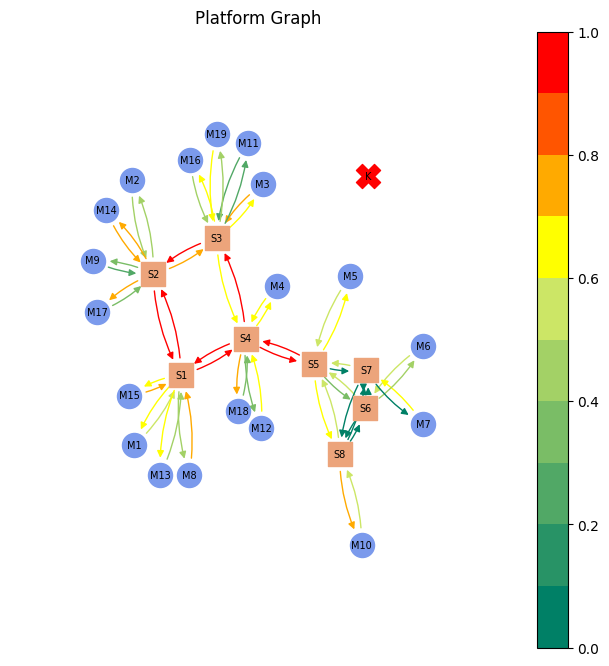

76


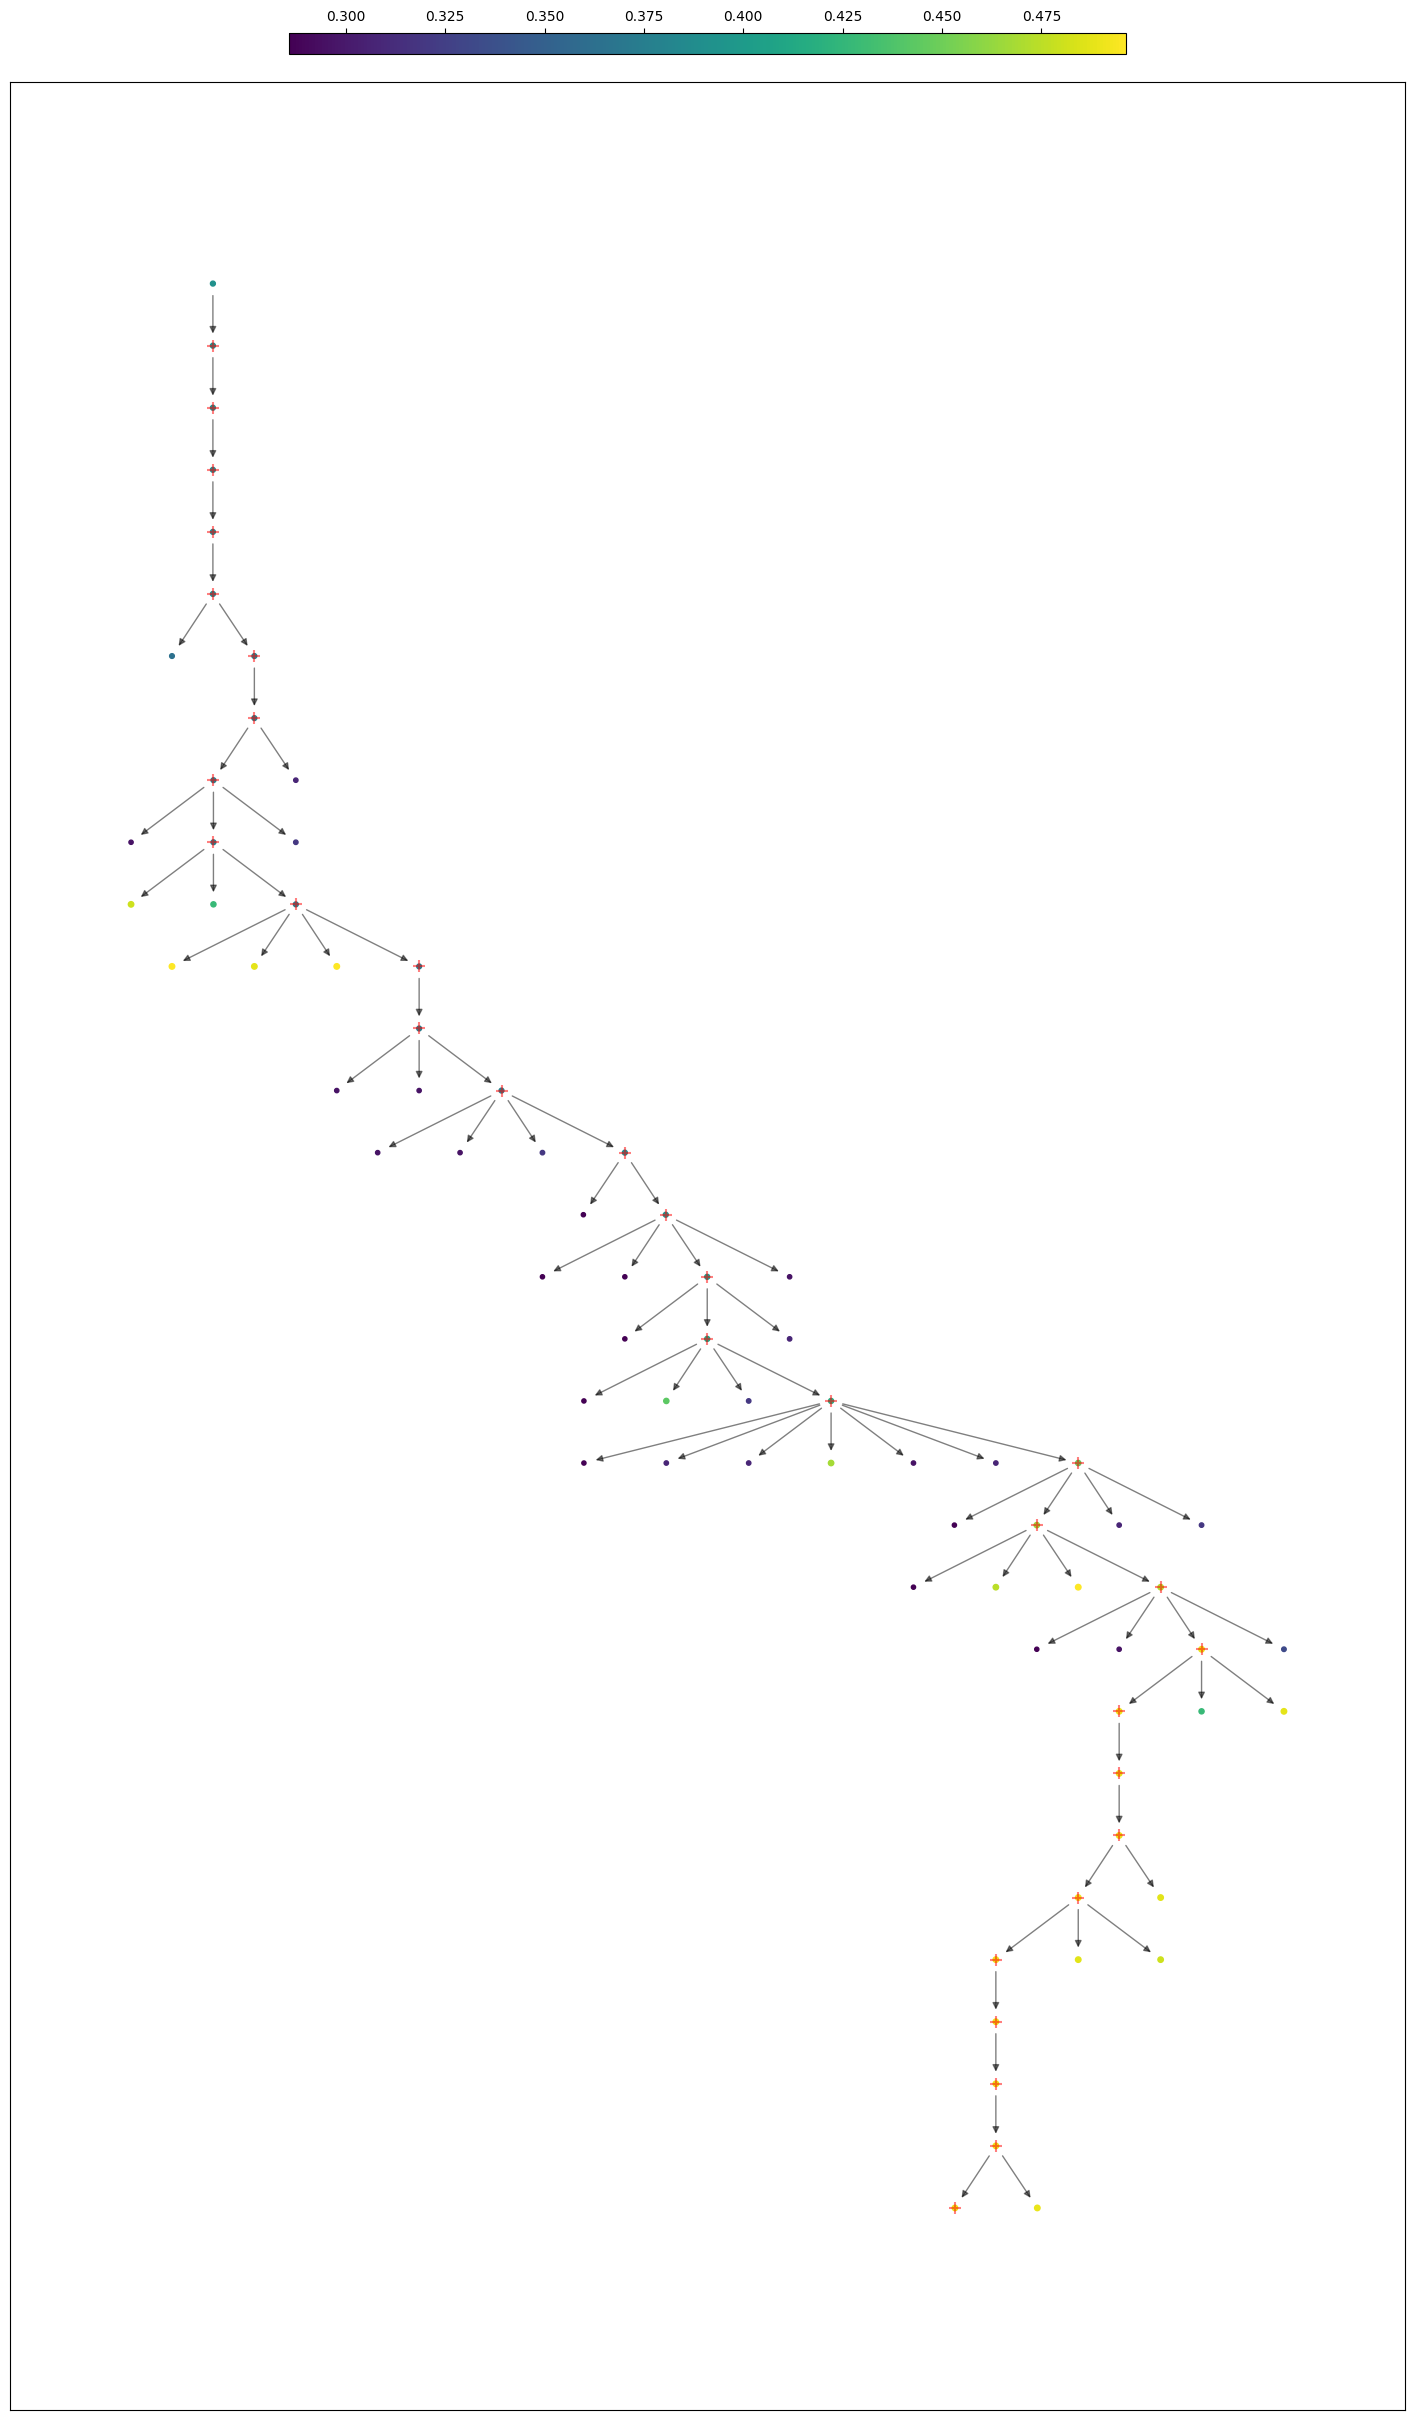

In [161]:
import matplotlib as plt
import time

def run_search(node,mct):
    root=node
    path=[]
    total_it=0
    for i in (pbar := tqdm(range(0,mct.max_depth))):
        selected_action, node, it = mct.search(node) 
        total_it+=it
        #print(selected_action[0])
        pbar.set_postfix({'iterations': it, 'nodes': len(mct.node_dict)})
        path.append(node)
        #node.state.draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']},size=(8,8),arc_rad=.125, edge_attribute="utilization")
        if node.state.is_terminal():
            if node.state.graph_evaluator.is_terminal(node.state):
                print("Exploration terminated: node is terminal by condition")
            else:
                print("Exploration terminated: node is terminal by rule starvation")
            return node, path, total_it
 
        
    return node, path

def outer_loop(print_tree=True,tree_filename=None):
    
    seed=2345423
    import os
    import time
    os.chdir("C:/Users\smora\Documents\LiU\Workspace")
    #print(os.getcwd())

    grammar_file = "NetGAP\grammars\grammar3_2.txt"
    grammar_loader = GrammarLoader(grammar_file)
    grammar = grammar_loader.load()

  
    graph_builder = GraphBuilder(grammar)
    
    weights={'latency': 12, 'connectivity': 6, 'cost' : 12}
  
    
    os.chdir("C:/Users\smora\Documents\LiU\Workspace\\NetGAP\models")
    #print(os.getcwd())
    
    
    hybrid_evaluator = HybridEvaluator( filename = "torch_model_911840",seed=seed,weights=weights)
    genetic_evaluator= GeneticEvaluator(weights=weights, pop_size=100, generations=3,seed=seed,\
                                            filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections.json")
    genetic_evaluator= GeneticRouter(weights=weights, pop_size=50, generations=3,seed=seed,\
                                            filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections.json")
       
    evaluator=genetic_evaluator
        
    rng=np.random.default_rng(seed)  
    seed=rng.integers(low=1,high=np.iinfo(np.int32).max)
    
    for i in range(1):
        print(f"Starting search with seed {seed}")
        #seed=rng.integers(low=1,high=np.iinfo(np.int32).max)
        
        evaluator.update_seed(seed)
        tree_policies=Policies(seed=seed)
        
        tree = MCST(iteration_limit=None, time_limit=1200, max_depth=40, transposition_check=True, exploration_constant=2*math.sqrt(2),\
                    rollout_policy= tree_policies.RandomPolicy, selection_policy= tree_policies.UCTPolicy)
        
        graph=nx.DiGraph()
        graph.add_nodes_from([(f'M{x}', {'idType': 'M'}) for x in range(1,20)])
        graph.add_node('K', idType='K')
        #graph.add_node('S1', idType='S')
        state = GraphState(graph_builder=graph_builder, graph_evaluator=evaluator,graph=graph) 
        root =  MonteCarloTreeNode(state)
        
        
        
        start = time.time()
        node,path,total_it = run_search(root,tree)
        end = time.time()
        time_diff=end-start
        
        results = tree.logger.log.values()
        sorted_results= sorted(results, key=lambda x: x.reward_stats["score"], reverse=True)
        
        for result in sorted_results:
            result.reward_stats.update({"search_time":time_diff})
        
        node.state.graph_evaluator = genetic_evaluator
        #node.state.get_reward()
        
        node.state.get_reward()
        print(f"Explored total of {len(tree.logger.log.values())} configurations for a total of {len(tree.logger.log.values())*100*3} solutions in {total_it} iterations")
        print(f"Monte Carlo tree  size: {len(tree.node_dict.values())} nodes")
        print("Solution Hash: ", hash(node.state))    
        print("Reward:", node.state.reward_stats)
    
    
    node.state.draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']},size=(8,8),arc_rad=.125, edge_attribute="utilization")
    
    if print_tree:    
        #plot_lat_vs_con(results)
        os.chdir("C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\\trees")
        tree_graph = MCSTreeGraph(root)
        tree_graph.draw(fig_size=(18,36),path=path,save_filename=tree_filename)
    
    return node, sorted_results
        
node, platform_list = outer_loop(print_tree=True)



[0.5746652935118435, 0.005980973414078301, 0.0012246845120848626]
{'max_load': 0.79999999999, 'overload_count': 0, 'mean_hops': 3.4802867383512543, 'max_hops': 5, 'latency_score': 0.5746652935118435, 'connectivity_score': 1.0, 'SW_connectivity': 1.0, 'shortest_routing_options': 47775744, 'total_cost': 270, 'cost_score': 0.7407407407407407, 'score': 0.726162447034367, 'num_modules': 19, 'num_switches': 8, 'num_links': 62, 'search_time': 49.8177227973938}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.40s/it]


[0.04744081329588777, 0.004674099864773311, 0.0005911970990500958]
{'max_load': 1.17994112, 'overload_count': 2, 'mean_hops': 3.5483870967741935, 'max_hops': 5, 'latency_score': 0.04744081329588777, 'connectivity_score': 1.0, 'SW_connectivity': 1.0, 'shortest_routing_options': 47775744, 'total_cost': 270, 'cost_score': 0.7407407407407407, 'score': 0.38160641447595706, 'num_modules': 19, 'num_switches': 8, 'num_links': 62}
{'max_load': 0.79999999999, 'overload_count': 0, 'mean_hops': 3.5268817204301075, 'max_hops': 5, 'latency_score': 0.5670731707317073, 'connectivity_score': 1.0, 'SW_connectivity': 1.0, 'shortest_routing_options': 47775744, 'total_cost': 270, 'cost_score': 0.7407407407407407, 'score': 0.6785391901535682, 'num_modules': 19, 'num_switches': 8, 'num_links': 62}


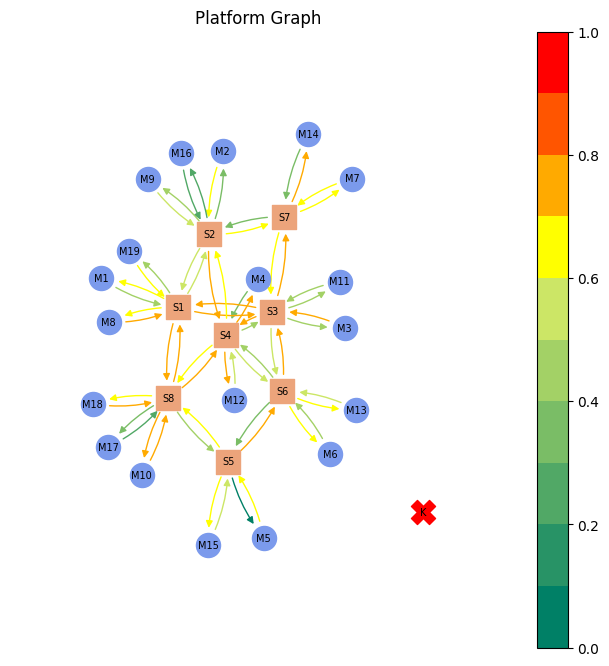

In [162]:
results=platform_list
best_results = sorted([x for x in results if x.reward_stats["num_switches"] in range(7,9) and x.reward_stats["latency_score"]>1e-3] , key=lambda x: x.reward_stats["latency_score"], reverse=True)[0:16]
print([x.reward_stats["latency_score"] for x in best_results])
print(best_results[0].reward_stats)
weights={'latency': 24, 'connectivity': 6, 'cost' : 12}

if False:
    for x in tqdm(best_results):
        x.graph_evaluator=GeneticEvaluator(weights=weights, pop_size=125, generations=8,seed=3458934, filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections.json")
        x.get_reward()
        best_results = sorted([x for x in best_results] , key=lambda x: x.reward_stats["latency_score"], reverse=True)
        print(best_results[0].reward_stats)
        print([x.reward_stats["latency_score"] for x in best_results])

    
if True:
    for x in tqdm(best_results[0:8]):
        x.graph_evaluator=GeneticRouter(weights=weights, pop_size=125, generations=8,seed=3458934, filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections.json")
        x.get_reward()

    best_results = sorted([x for x in best_results] , key=lambda x: x.reward_stats["latency_score"], reverse=True)
    print([x.reward_stats["latency_score"] for x in best_results])
    print(best_results[0].reward_stats)

best_results[0].graph_evaluator=GeneticRouter(weights=weights, pop_size=500, generations=16,seed=3458934, filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections.json")
best_results[0].get_reward()

print(best_results[0].reward_stats)
best_results[n].draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']},size=(8,8),arc_rad=.125,edge_attribute="utilization")



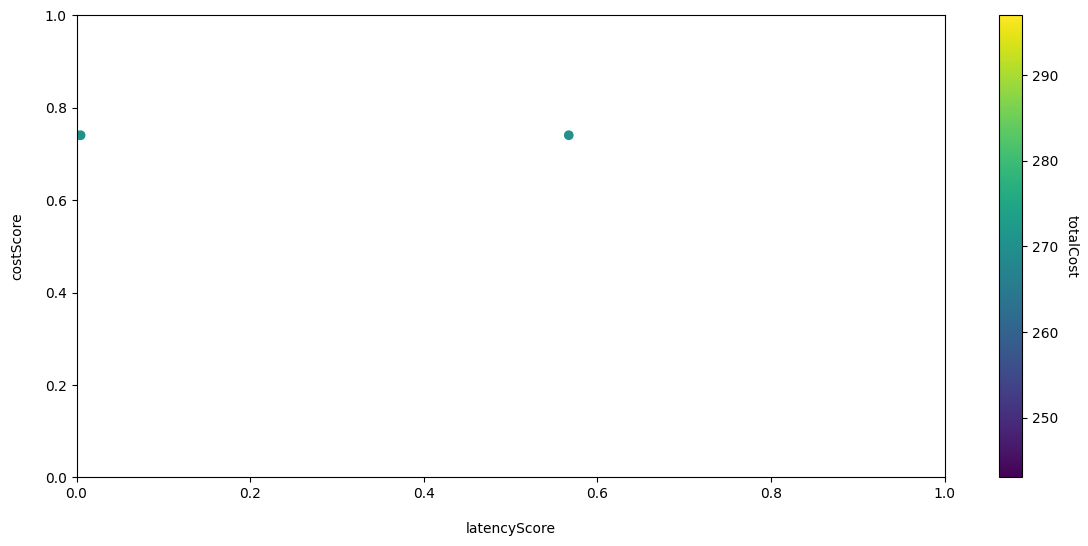

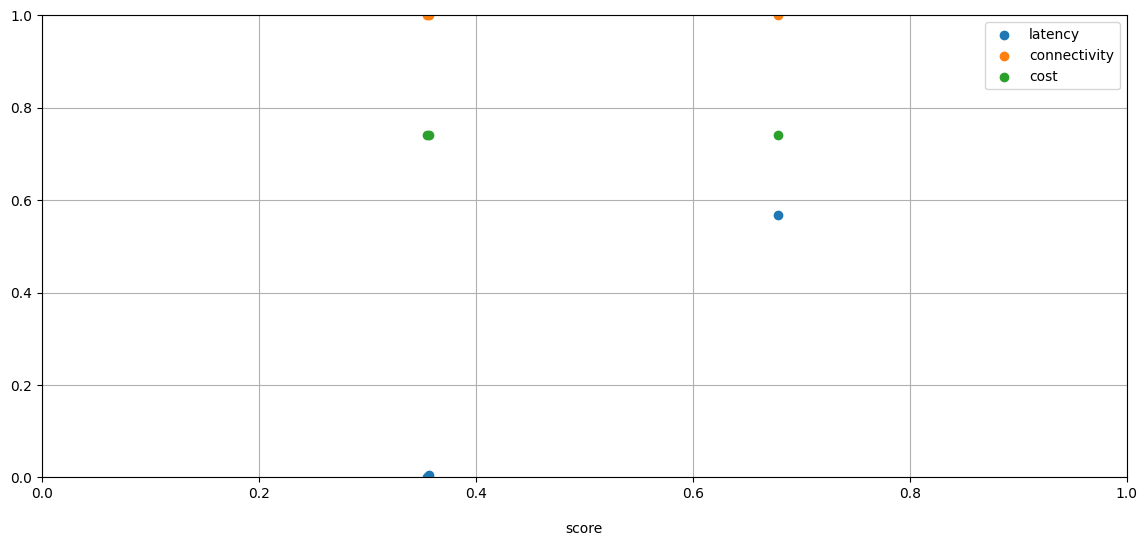

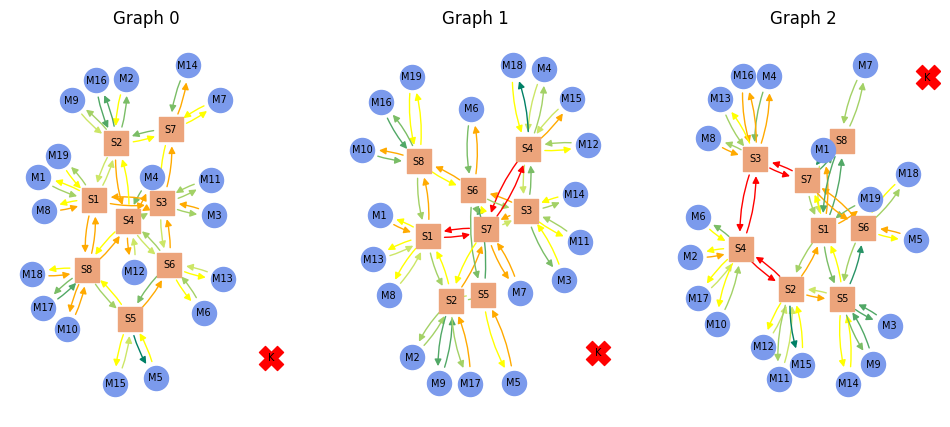

In [163]:
graphs=[st.graph for st in best_results]
plot_platform_stats(best_results)
drawMultipleGraphs(graphs, type_map={'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']}, max_rows=4, arc_rad=.125,edge_attribute="utilization")

In [ ]:
best_results[0].graph_evaluator=GeneticRouter(weights=weights, pop_size=100, generations=5,seed=123423, filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections.json")
best_results[0].get_reward()

print(best_results[0].reward_stats)
print(best_results[0].depth)
best_results[n].draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']},size=(8,8),arc_rad=.125,edge_attribute="utilization")


In [159]:
best_results[0].reward_stats["latency_score"] > 0.2:

    filename=f"feasible_6p{reward_stats["]}"
    now = datetime.datetime.now()
    date= f"{now.month}{now.day}{now.hour}{now.minute}"
    filename += f"_{date}"

    best_results[0].save_to_file('C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\example_graphs',filename)

    nx.write_gexf(best_results[0].graph,f'C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\example_graphs\{filename}.gexf')



will write graph_state object to file  C:/Users\smora\Documents\LiU\Workspace\NetGAP\data\example_graphs\feasible_6p7s_11281155.json
